In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import os
from mpl_toolkits import mplot3d
%matplotlib inline
%matplotlib notebook

<IPython.core.display.Javascript object>


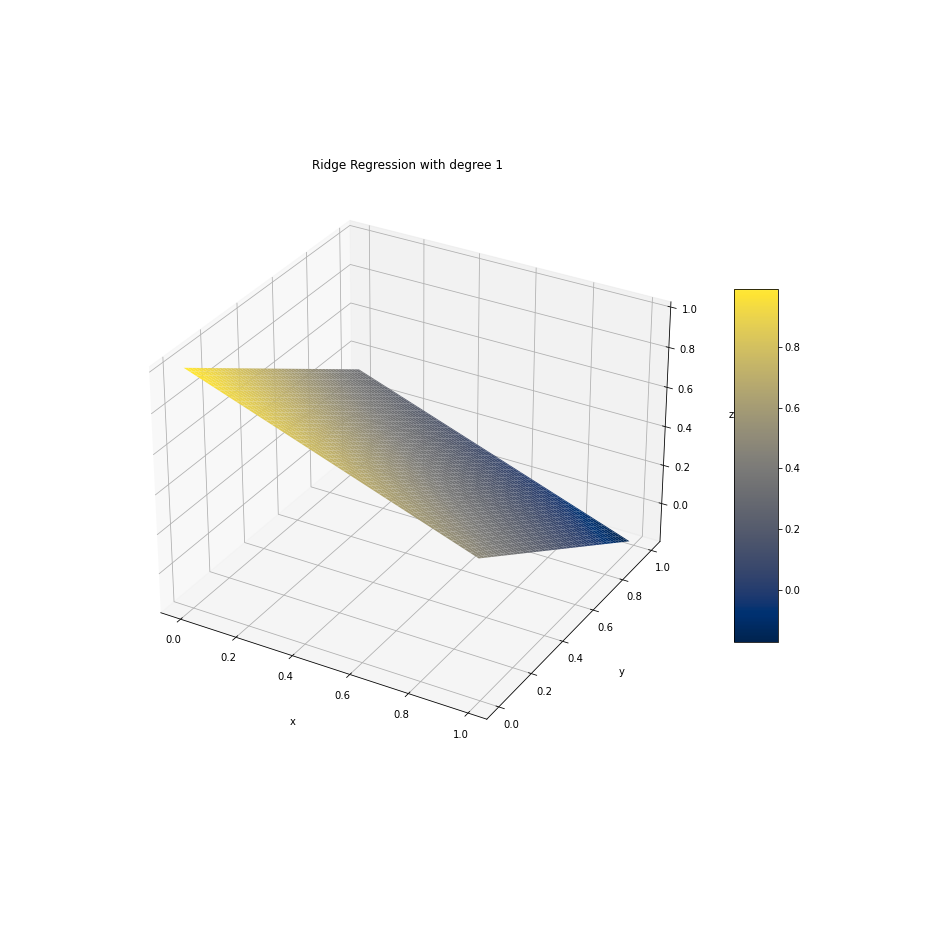

<IPython.core.display.Javascript object>


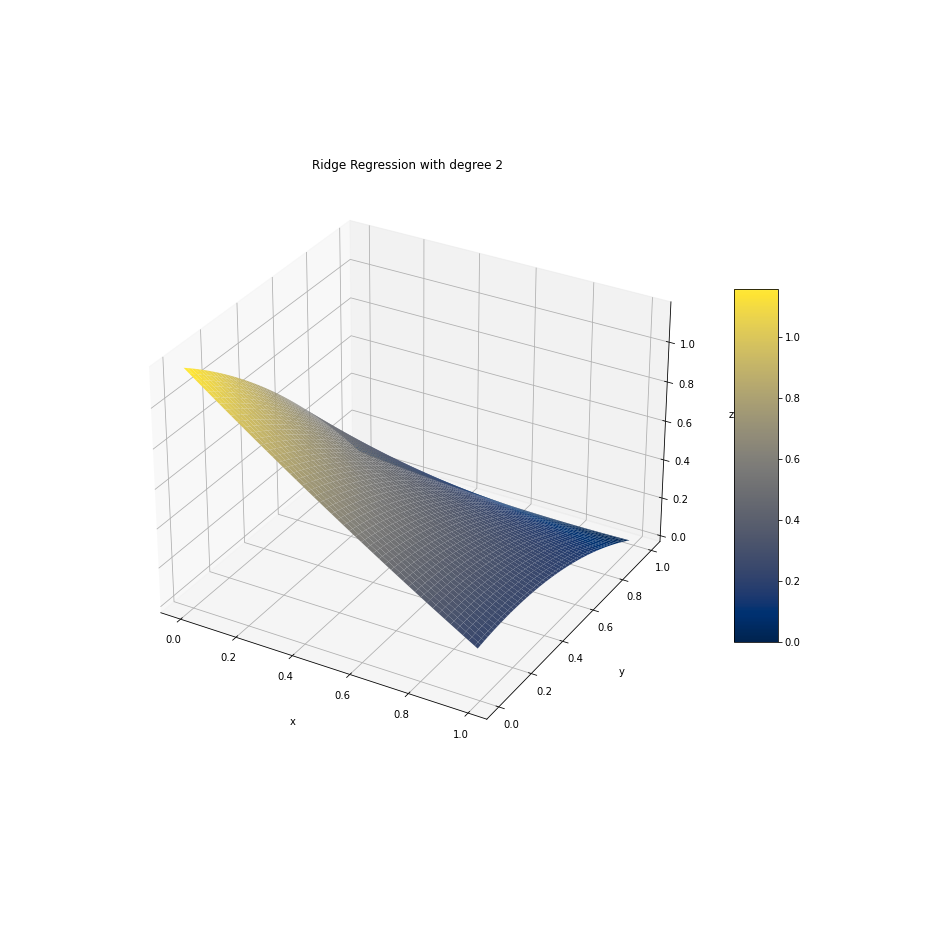

<IPython.core.display.Javascript object>


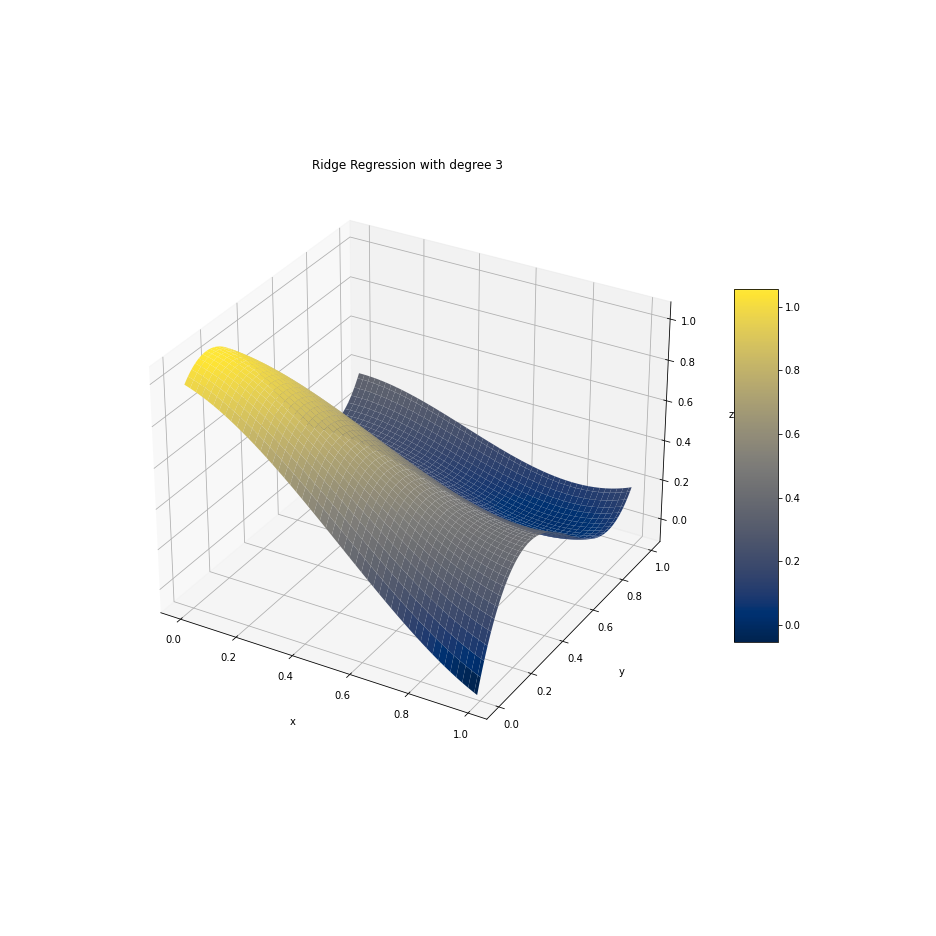

<IPython.core.display.Javascript object>


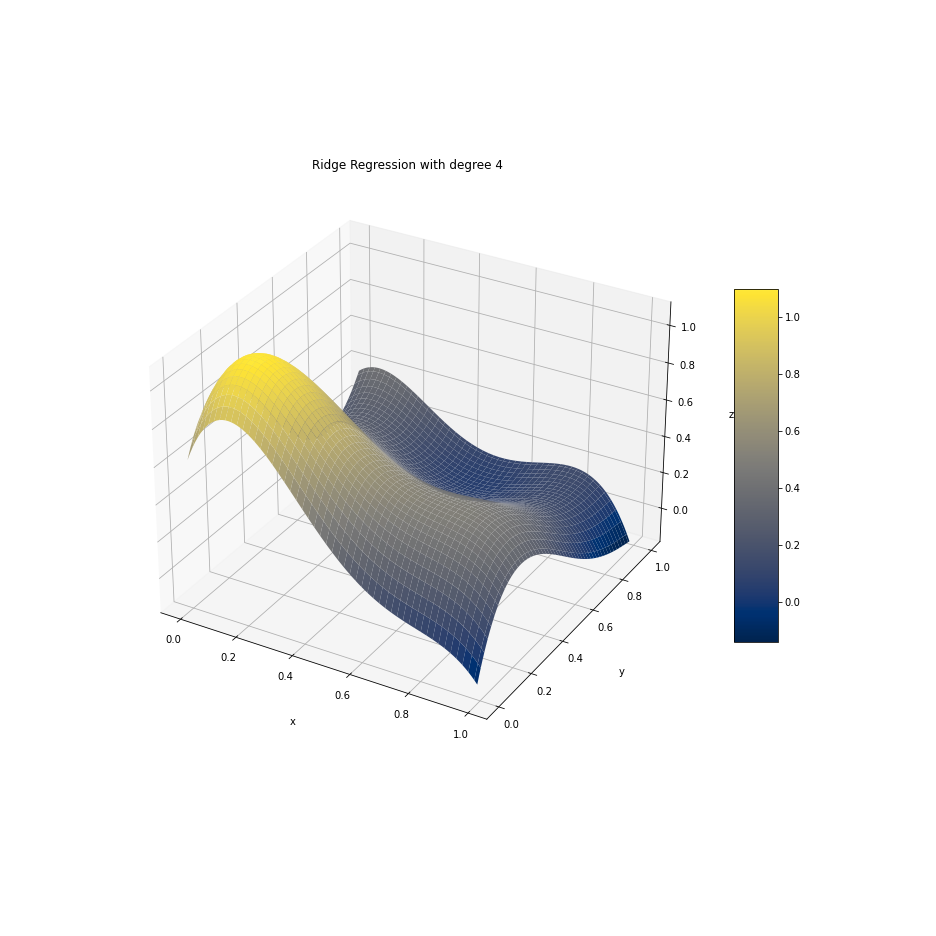

<IPython.core.display.Javascript object>


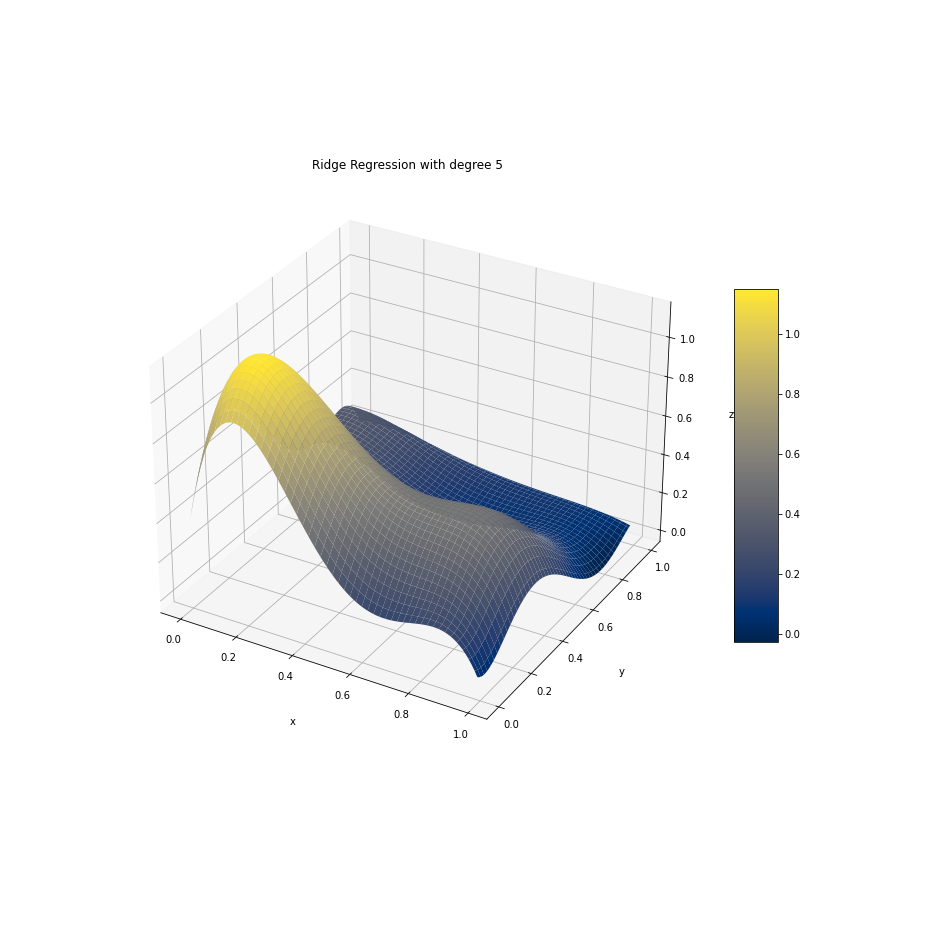

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

def MSE(y, y_hat):
    return np.mean(np.square(y - y_hat))

def z_score(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)


# Create data
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)

x, y = np.meshgrid(x,y)


# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)

# Compute z
z = FrankeFunction(x, y)

# Get labels
labels = z.ravel()

Lambda = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for l in enumerate(Lambda):
    def Ridge(x_train, y_train, l):
        beta = np.linalg.pinv(x_train.T @ x_train + l*np.identity(x_train.shape[1]) ) @ x_train.T @ y_train
        return beta

# Scaling data
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)

# Create the matrix of features
degree = [1, 2, 3, 4, 5]


for d in degree:
  poly = PolynomialFeatures(d)
  x_train_poly = poly.fit_transform(x_train)
  x_test_poly = poly.transform(x_test)


  fig = plt.figure(figsize=(13, 13))
  ax = plt.axes(projection='3d')
  
# Determine optimal parameters with ridge regression
  beta = Ridge(x_train_poly, y_train, 0.000001)
  
  Y_hat = poly.fit_transform(features) @ beta

  surf = ax.plot_surface(x, y, Y_hat.reshape(x.shape), cmap = plt.cm.cividis)
  fig.colorbar(surf, shrink=0.5, aspect=8)
  ax.set_title('Ridge Regression with degree '+ str(d))
  ax.set_xlabel('x', labelpad=20)
  ax.set_ylabel('y', labelpad=20)
  ax.set_zlabel('z', labelpad=20)

  plt.show()

In [13]:
n_boostraps = 1000
degree_values = np.arange(1, 6)  # Specify degree of polynomial to be fitted
k_values  = [5, 6, 7, 8, 9, 10]  # Number of folds

Lambda = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    
def bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1):
  
    Maxpolydegree = np.max(degree_values)
    error_test = np.zeros((Maxpolydegree,  len(k_values)))
    bias_test = np.zeros((Maxpolydegree,  len(k_values)))
    variance_test = np.zeros((Maxpolydegree,  len(k_values)))

    error_train = np.zeros((Maxpolydegree,  len(k_values)))
    bias_train = np.zeros((Maxpolydegree,  len(k_values)))
    variance_train = np.zeros((Maxpolydegree,  len(k_values)))


    if add_noise :
        np.random.seed(1)
        labels = labels +  np.random.normal(mean, std, labels.shape )
        
    for l in enumerate(Lambda):
        def Ridge_b(x_train, y_train, l):
            beta_b = np.linalg.pinv(x_train.T @ x_train + l*np.identity(x_train.shape[1]) ) @ x_train.T @ y_train
            return beta_b
        for n,k in enumerate(k_values):
            # Hold out some test data that is never used in training.
            x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                            test_size=1/k, random_state = 2021)
    

            for nd, degree in enumerate(degree_values):
                # Input features transformation 
                poly = PolynomialFeatures(degree = degree)
                X_train_poly= poly.fit_transform(x_train)
                X_test_poly= poly.fit_transform(x_test)
                # The following (m x n_bootstraps) matrix holds the column vectors y_pred
                # for each bootstrap iteration.
                y_pred = np.empty((y_test.shape[0], n_boostraps))   ## test set
                y_pred_train = np.empty((y_train.shape[0], n_boostraps))   ## train set

            for i in range(n_boostraps):
                x_, y_ = resample(X_train_poly, y_train)
                y_pred_train[:, i] = X_train_poly @ Ridge_b(x_, y_, l).ravel()
                y_pred[:, i] = X_test_poly @ Ridge_b(x_, y_, l).ravel()

            #compute error, bias^2 and variance 
            error_test[nd,n] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
            bias_test[nd,n] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
            variance_test[nd,n] = np.mean( np.var(y_pred, axis=1, keepdims=True) )

            error_train[nd,n] = np.mean( np.mean((y_train - y_pred_train)**2, axis=1, keepdims=True) )
            bias_train[nd,n] = np.mean( (y_train - np.mean(y_pred_train, axis=1, keepdims=True))**2 )
            variance_train[nd,n] = np.mean( np.var(y_pred_train, axis=1, keepdims=True) )

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 

In [14]:
def gen_plot_bootstrap(k_values, polynomial, estimated_mse, title , y_label, legend_label):
    for n,k in enumerate(k_values):
        plt.plot(polynomial, estimated_mse[:, n], label= legend_label +'size = '+str(np.round(1/k, 2))+', k = '+ str(k)  )
        plt.xlabel('Polynomial degree')
        plt.ylabel( y_label)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

In [15]:
for j in enumerate(Lambda):
    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , k_values, degree_values, 
                              scaling= True , add_noise= True, mean = 0, std = 1)
Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree

 # plot bias-variance tradeoff
for n,k in enumerate(k_values): 
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))
    ax0.plot(polynomial, error_test[:, n], label= 'Error')
    ax0.plot(polynomial, bias_test[:, n], label= 'Bias')
    ax0.plot(polynomial, variance_test[:, n], label= 'Variance')
    ax0.set_xlabel('Model complexity')
    ax0.set_ylabel('Error')
    ax0.legend()
    ax0.set_title('BV Trade-off: test data size = '+str(np.round(1/k, 2))+', k = '+ str(k))

    ax1.plot(polynomial, error_train[:, n], label= 'Error')
    ax1.plot(polynomial, bias_train[:, n], label= 'Bias')
    ax1.plot(polynomial, variance_train[:, n], label= 'Variance')
    ax1.set_xlabel('Model Complexity')
    ax1.set_ylabel('Error')
    ax1.legend()
    ax1.set_title('BV Trade-off: train data size = '+str(np.round(1-1/k, 2))+', k = '+ str(k))
    
   

ValueError: operands could not be broadcast together with shapes (2,) (21,21) 